In [1]:
import sys
sys.path.append('..')
import numpy as np
import pickle 
import matplotlib.pyplot as plt
from utils import d_sl, years, compute_weights_lon, ssp, version, DATA_PATH
from sklearn.linear_model import LinearRegression
from produce_maps.tcrit import data_both_biomes
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

d_ext = {"South America": "south_america",  "Africa": "africa", "SE Asia": "south_east_asia"}
d_ext = {value: key for key, value in d_ext.items()}
d_ext_latex = { # for latex
    "South America": 'SA',
    "SE Asia": 'SEA',
    "Africa": "A"
}
plt.rcParams.update({'font.size': 20})


# Relies on outputs of biome_continent_per_year.py and slope.py

0.8 SE Asia 0.018185425310045744 7.849001220703123
0.9 SE Asia 0.01857226903299658 4.532507324218756
0.8 South America 0.07466527919056354 6.61584610062458
0.9 South America 0.07519415370367888 2.723473262974508
0.8 Africa 0.03965723797626275 8.898949695324115
0.9 Africa 0.015136535830896136 5.129992675781253


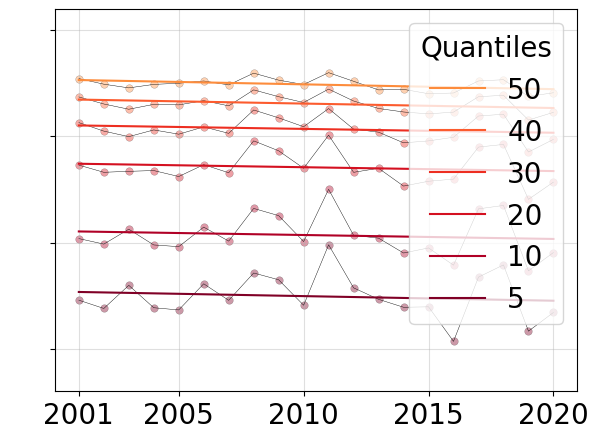

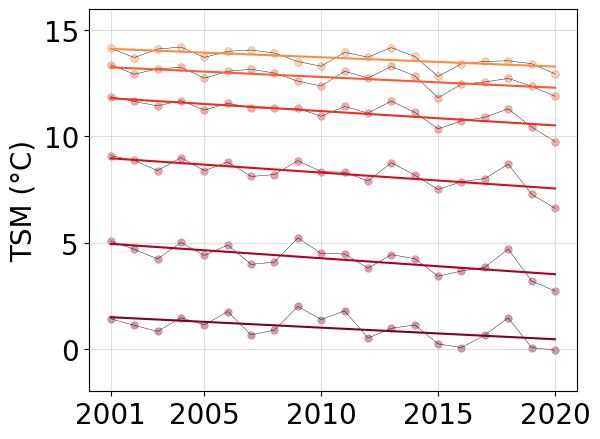

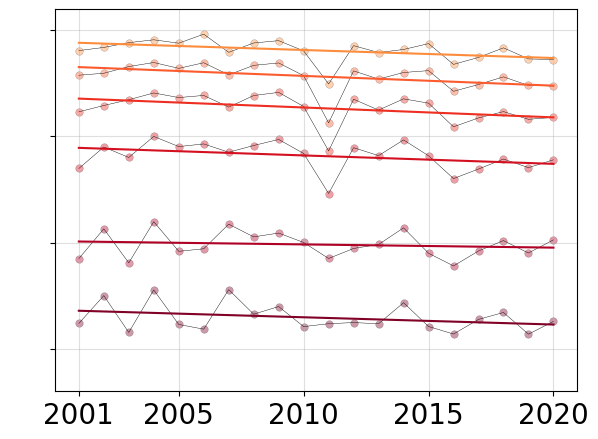

In [10]:
def f(sl, ext):
    outfile = DATA_PATH + f'/outputs/continents/quantilesTSM_{"_".join(years)}_{ext}_Tcrit_Tcritmean_{ssp}{version}.pkl'
    with open(outfile, 'rb') as file:
        d_hansen_temp = pickle.load(file)
    return d_hansen_temp

points = np.linspace(0.5, 1.0, 6)
colormap = plt.get_cmap('YlOrRd')
colors = [colormap(point) for point in points]
quantiles = ['median', '0.6', '0.7', '0.8', '0.9', '0.95']


for key, sl in d_sl.items():
    ext = key
    key = d_ext[key]
    legend = key 
    fig = plt.figure()
    ax = fig.gca()
    ax.tick_params(axis='y')
    if key == "South America":
        ax.set_ylabel("TSM (°C)")
    linestyle = 'solid'
    d_hansen_temp = f(sl, ext)


    for color, quantile in zip(colors, quantiles):
        min_median = d_hansen_temp[quantile]
        min_median = -1 * np.asarray([min_median[i][0] for i in range(len(d_hansen_temp[quantile].keys()))])
        min_median = min_median#[:-2]

        model_min_median = LinearRegression()
        X = np.arange(len(years)).reshape(-1, 1)
        model_min_median.fit(X, min_median)
        y = model_min_median.predict(X)
        if quantile == '0.9' or quantile == '0.8':
            # pass
            print(quantile, key, y[0]-y[1], min_median[-1])
        coef = np.round(model_min_median.coef_[0], 4)
        x = np.arange(len(min_median))
        ax.plot(x, min_median, color='black', linewidth=0.3)
        ax.plot(years, y, color=color, linestyle=linestyle)
        plt.scatter(x, min_median, color=color, edgecolor='black', linewidth=.25, s=30, alpha=0.4)
        
        
        ax.set_xticks([0, 4, 9, 14, 19], [2001, 2005, 2010, 2015, 2020])
        if quantile == 'median':
            quantile = '0.5'
        ax.plot([], c=color, label=str(int(100*np.round(1-float(quantile), 2))))
        plt.ylim(-2,16)
        
    plt.grid(alpha=0.4)
    if key != "South America":
        plt.gca().yaxis.set_tick_params(labelcolor='none')
    if key == "SE Asia":
        
        ax.legend(title="Quantiles", loc=1)
    plt.tight_layout() 
    plt.savefig(f"../figures/Figure2/TSM_LR/{d_ext_latex[key]}.png", bbox_inches='tight')
    

[3.55310508 3.82285321 4.00640153 3.39560144 3.69270697 3.01803827
 4.24314442 3.95032353 2.75336544 3.42658402 2.67998184 4.39388556
 3.91076869 3.67957402 4.72064849 4.9377338  4.22483705 3.48648404
 4.92414895 5.09138594]


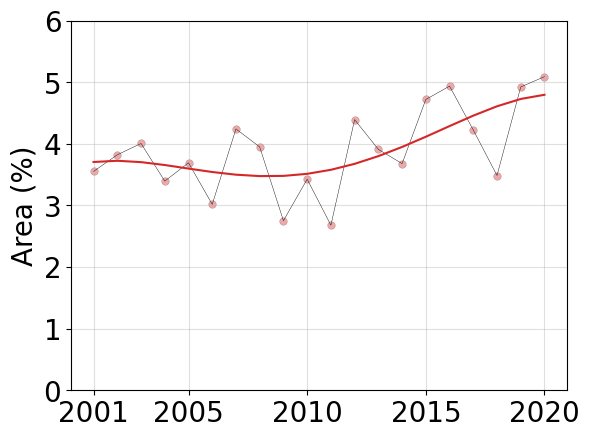

In [16]:
# Polynomial 
for key, sl in list(d_sl.items()):
    ext = key
    key = d_ext[key]
    if key != "South America":
        continue
    color = 'tab:red' 
    outfile = DATA_PATH + f"/outputs/delta_Tmean_Tmodis{ext}_per_year_2001_2020_reversed{version}.npy"
    map = np.load(outfile)
    map = map.astype(float)
    map[~data_both_biomes[sl]] = np.nan
    weights_lon = compute_weights_lon(sl)
    above_threshold_map =  ((map > 0).transpose((2,0,1)) * weights_lon).transpose((1,2,0))
    above_threshold_map = above_threshold_map.astype(float)
    above_threshold_map[np.isnan(map)] = np.nan
    above_thresholds = np.nansum(np.nansum(above_threshold_map, axis=0) , axis=0)
    y = above_thresholds/np.sum(~np.isnan(map[...,0]) * weights_lon)*100 

    model = LinearRegression()
    model = make_pipeline(PolynomialFeatures(4), Ridge(alpha=1e-5))
    X = np.arange(len(years)).reshape(-1, 1)
    model.fit(X, y)
    pred = model.predict(X)
    x = np.arange(len(y))
        
    fig = plt.figure()
    ax = fig.gca()
    ax.tick_params(axis='y')
    ax.set_ylabel("Area (%)")
    ax.plot(x, y, color='black', linewidth=0.3)
    ax.plot(years, pred, color=color, label=key)
    print(y)
    plt.scatter(x, y, color=color, edgecolor='black', linewidth=.25, s=30, alpha=0.4)


    ax.set_xticks([0, 4, 9, 14, 19], [2001, 2005, 2010, 2015, 2020])
    plt.ylim(0,6)
    plt.grid(alpha=0.4)
    plt.savefig(f"../figures/Figure2/surface_over_threshold/{d_ext_latex[key]}.png", bbox_inches='tight')

[2.59182212 2.88659362 2.00289309 2.75996055 2.94275138 1.73546703
 2.45287459 1.62426871 1.89629934 2.80067665 0.80436408 1.83719767
 2.42059227 2.50439644 2.69943756 4.61428952 1.96319313 1.39984981
 3.9479246  3.141943  ]


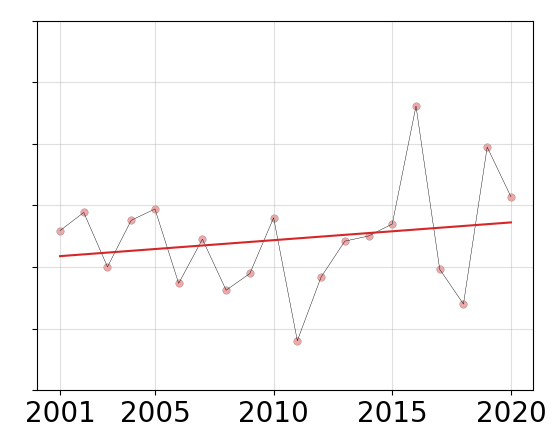

In [17]:
for key, sl in list(d_sl.items()):
    ext = key
    key = d_ext[key]
    if key != "SE Asia":
        continue
    color = 'tab:red'
    outfile = DATA_PATH + f"/outputs/delta_Tmean_Tmodis{ext}_per_year_2001_2020_reversed{version}.npy"
    map = np.load(outfile)
    map = map.astype(float)
    map[~data_both_biomes[sl]] = np.nan
    weights_lon = compute_weights_lon(sl)
    above_threshold_map =  ((map > 0).transpose((2,0,1)) * weights_lon).transpose((1,2,0))
    above_threshold_map = above_threshold_map.astype(float)
    above_threshold_map[np.isnan(map)] = np.nan
    above_thresholds = np.nansum(np.nansum(above_threshold_map, axis=0) , axis=0)
    y = above_thresholds/np.sum(~np.isnan(map[...,0]) * weights_lon)*100 #ICI weights_lon

    model = LinearRegression()
    X = np.arange(len(years)).reshape(-1, 1)
    model.fit(X, y)
    pred = model.predict(X)
    x = np.arange(len(y))
        
    fig = plt.figure()
    ax = fig.gca()
    ax.tick_params(axis='y')
    ax.plot(x, y, color='black', linewidth=0.3)
    ax.plot(years, pred, color=color, label=key)
    plt.scatter(x, y, color=color, edgecolor='black', linewidth=.25, s=30, alpha=0.4)


    ax.set_xticks([0, 4, 9, 14, 19], [2001, 2005, 2010, 2015, 2020])
    plt.ylim(0,6)
    plt.grid(alpha=0.4)
    plt.gca().yaxis.set_tick_params(labelcolor='none')
    print(y)
    plt.gca().yaxis.set_tick_params(labelcolor='none')
    plt.savefig(f"../figures/Figure2/surface_over_threshold/{d_ext_latex[key]}.png", bbox_inches='tight')

[3.62888069 2.57386065 4.05669    2.35140162 3.79865483 4.0423964
 2.39218873 3.33510408 3.08559765 3.94523034 3.62328233 3.65600211
 3.89025825 3.03683518 3.78622995 4.22355203 3.59125773 3.29974949
 4.30918916 3.86854818]


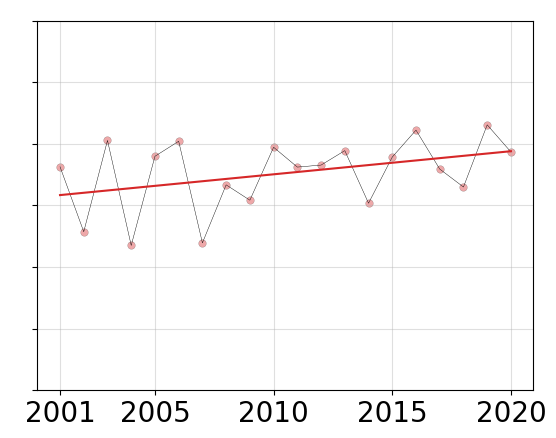

In [18]:


for key, sl in list(d_sl.items()):
    ext = key
    key = d_ext[key]
    if key != "Africa":
        continue
    color = 'tab:red'
    outfile = DATA_PATH + f"/outputs/delta_Tmean_Tmodis{ext}_per_year_2001_2020_reversed{version}.npy"
    map = np.load(outfile)
    map = map.astype(float)
    map[~data_both_biomes[sl]] = np.nan
    weights_lon = compute_weights_lon(sl)
    above_threshold_map =  ((map > 0).transpose((2,0,1)) * weights_lon).transpose((1,2,0))
    above_threshold_map = above_threshold_map.astype(float)
    above_threshold_map[np.isnan(map)] = np.nan
    above_thresholds = np.nansum(np.nansum(above_threshold_map, axis=0) , axis=0)
    y = above_thresholds/np.sum(~np.isnan(map[...,0]) * weights_lon)*100 #ICI weights_lon

    model = LinearRegression()
    X = np.arange(len(years)).reshape(-1, 1)
    model.fit(X, y)
    pred = model.predict(X)
    x = np.arange(len(y))
        
    fig = plt.figure()
    ax = fig.gca()
    ax.tick_params(axis='y')
    ax.plot(x, y, color='black', linewidth=0.3)
    ax.plot(years, pred, color=color, label=key)
    plt.scatter(x, y, color=color, edgecolor='black', linewidth=.25, s=30, alpha=0.4)


    ax.set_xticks([0, 4, 9, 14, 19], [2001, 2005, 2010, 2015, 2020])
    plt.ylim(0,6)
    plt.grid(alpha=0.4)
    print(y)
    plt.gca().yaxis.set_tick_params(labelcolor='none')
    plt.savefig(f"../figures/Figure2/surface_over_threshold/{d_ext_latex[key]}.png", bbox_inches='tight')